In [1]:
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
f = uproot.open("/data1/hagaman/xin_files/processed_checkout_rootfiles/prodgenie_bnb_nc_delta_overlay_run3_PF/UBGenieFluxSmallUni.root")["wcpselection"]
weights_df = f["T_weight"].pandas.df(["run", "subrun", "event", "All_UBGenie", "weight_cv", "weight_spline"], flatten=False)
eval_df = f["T_eval"].pandas.df(["match_isFC"], flatten=False)
pf_eval_df = f["T_PFeval"].pandas.df(["truth_pdg", "truth_mother", "truth_startMomentum", "reco_showerKE"], flatten=False)
bdt_df = f["T_BDTvars"].pandas.df(["nc_delta_score"], flatten=False)
kine_df = f["T_KINEvars"].pandas.df(["kine_reco_Enu", "kine_energy_particle", "kine_particle_type"], flatten=False)

nc_delta_df = pd.concat([weights_df, eval_df, pf_eval_df, bdt_df, kine_df], axis=1, sort=False)

del f
del weights_df
del eval_df
del pf_eval_df
del bdt_df
del kine_df


In [3]:
# adding truth primary particle nums, only for NC Delta

num_protons_prim_35s = []

truth_pdgs = nc_delta_df["truth_pdg"].to_numpy()
truth_mothers = nc_delta_df["truth_mother"].to_numpy()
truth_startMomentums = nc_delta_df["truth_startMomentum"].to_numpy()

for i in tqdm(range(nc_delta_df.shape[0])):

    num_protons_prim_35 = 0
    
    max_pion_true_kinetic_energy = 0
    max_proton_true_kinetic_energy = 0
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]

    for j in range(len(truth_pdg_list)):
        if truth_mother_list[j] == 0 and truth_pdg_list[j] == 2212: # primary proton
            proton_kinetic_energy = 1000. * truth_startMomentum_list[j][3] - 938.272
            if proton_kinetic_energy > 35.:
                num_protons_prim_35 += 1

    num_protons_prim_35s.append(num_protons_prim_35)

nc_delta_df["num_protons_prim_35"] = num_protons_prim_35s


  0%|          | 0/93817 [00:00<?, ?it/s]

In [4]:
proton_nums = []
track_nums = []
energy_lists = nc_delta_df["kine_energy_particle"].to_numpy()
pdg_lists = nc_delta_df["kine_particle_type"].to_numpy()
for i in tqdm(range(nc_delta_df.shape[0])):
    proton_num = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    track_nums.append(track_num)
nc_delta_df["num_protons"] = proton_nums
nc_delta_df["num_other_tracks"] = track_nums


  0%|          | 0/93817 [00:00<?, ?it/s]

In [5]:
filtered_df = nc_delta_df.query("match_isFC==0 and 0 < kine_reco_Enu < 1500" 
                                + " and num_protons_prim_35 > 0"
                                + " and nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons > 0")
#filtered_df = nc_delta_df

filtered_df.shape[0]


371

In [6]:
#filtered_df

In [7]:
genie_all_weights = filtered_df["All_UBGenie"].to_numpy()
cv_weights = filtered_df["weight_cv"].to_numpy()
spline_weights = filtered_df["weight_spline"].to_numpy()

print(genie_all_weights.shape, cv_weights.shape, spline_weights.shape)

(371,) (371,) (371,)


In [8]:
total_genie_all_weights = []
for i in tqdm(range(genie_all_weights[0].shape[0])): # looping over universes
    total_weight = 0
    for j in range(genie_all_weights.shape[0]): # looping over events
        total_weight += genie_all_weights[j][i] * spline_weights[j]
    total_genie_all_weights.append(total_weight)
    
total_cv_genie_weight = np.sum(cv_weights * spline_weights)


  0%|          | 0/600 [00:00<?, ?it/s]

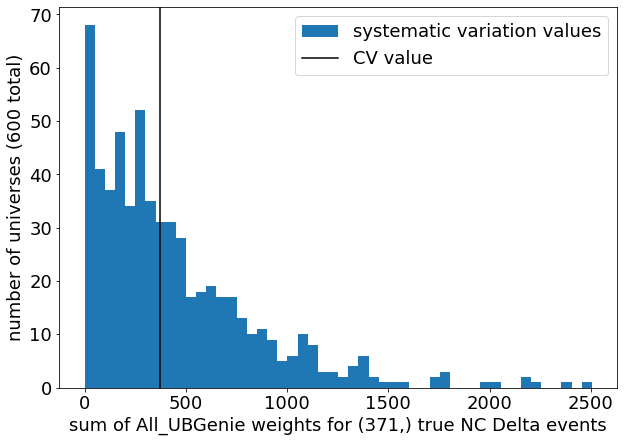

In [9]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10, 7))
plt.hist(total_genie_all_weights, bins=50, label="systematic variation values")
plt.axvline(total_cv_genie_weight, c="k", label="CV value")
plt.xlabel(f"sum of All_UBGenie weights for {cv_weights.shape} true NC Delta events")
plt.ylabel("number of universes (600 total)")
plt.legend()
plt.show()

In [10]:
diffs = total_genie_all_weights - total_cv_genie_weight

covariance = np.sum(diffs * diffs) / genie_all_weights[0].shape[0]

print("from manual investigation of All_UBGenie weights in different universes for the run 1 NC Delta file:\n")

print("CV value: ", total_cv_genie_weight)
print("variance: ", covariance)
print("fractional variance: ", covariance / (total_cv_genie_weight * total_cv_genie_weight))

from manual investigation of All_UBGenie weights in different universes for the run 1 NC Delta file:

CV value:  371.0
variance:  172198.18010849704
fractional variance:  1.2510674879468837


[0.04589441 0.         1.02497821 0.         1.00521562 0.
 0.0367378  0.         1.01488309 0.         1.00649247 0.        ]


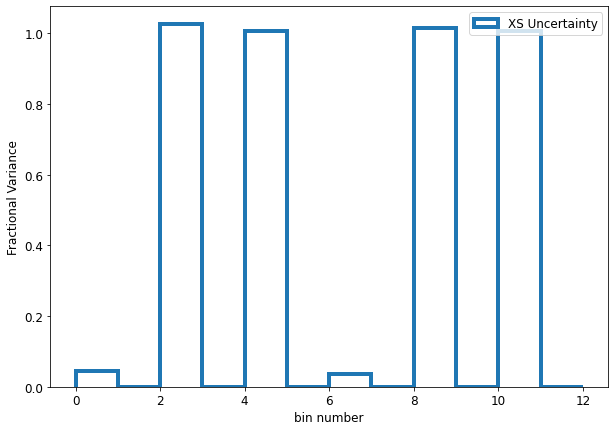

In [11]:
import uproot as uproot

f_cov = uproot.open(f"~/wc_framework/LEEana/hist_rootfiles/XsFlux/cov_17.root")

frac_cov_mat = f_cov[f"frac_cov_xf_mat_17"].member("fElements")
frac_cov_mat = frac_cov_mat.reshape((272, 272))

diagonal_fractional_variances = []
for i in range(272):
    diagonal_fractional_variances.append(frac_cov_mat[i,i])

    
print(np.nan_to_num(np.array(diagonal_fractional_variances[:12])))
    
lw = 4
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,7))
plt.hist([_+0.5 for _ in range(12)], weights=np.nan_to_num(np.array(diagonal_fractional_variances[:12])), 
         bins=12, range=(0, 12), histtype="step", lw=lw, label="XS Uncertainty")
plt.xlabel("bin number")
plt.ylabel("Fractional Variance")
plt.legend()
plt.show()

